# Question 1

**ML model to warn the person's condition based on behavior pattern.**


The hypothesis that cervical cancer (also known as ca cervix) can also be       detected early based on the social and cognitive behavior patterns which has been proved in early 2000s (can cite the papers if needed). As this disease doesn’t develop any symptoms, it is very common that people seek care only at the advanced stage. But since behaviors and perceptions are deeply influenced by the body’s response to the internal changes, theory suggests there are seven determinants of behavior to analyze a person’s condition. Based on these factors we create a ML model that can warn a person to have regular screening tests.

As there is no permanent cure to this problem, this model could at least warn the people in the early stages to consider the screening and avoid any delay the treatment.

In [3]:
!pip install pyspark
!pip install imbalanced-learn

import imblearn
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from imblearn.over_sampling import SMOTE
from pyspark.sql.functions import when,lit,col
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, LogisticRegression

In [4]:
data = pd.read_csv('sobar-72.csv')
columns = list(data.columns)
columns.remove('ca_cervix')
cols = columns
cols

['behavior_sexualRisk',
 'behavior_eating',
 'behavior_personalHygine',
 'intention_aggregation',
 'intention_commitment',
 'attitude_consistency',
 'attitude_spontaneity',
 'norm_significantPerson',
 'norm_fulfillment',
 'perception_vulnerability',
 'perception_severity',
 'motivation_strength',
 'motivation_willingness',
 'socialSupport_emotionality',
 'socialSupport_appreciation',
 'socialSupport_instrumental',
 'empowerment_knowledge',
 'empowerment_abilities',
 'empowerment_desires']

In [5]:
data.isnull().sum()

behavior_sexualRisk           0
behavior_eating               0
behavior_personalHygine       0
intention_aggregation         0
intention_commitment          0
attitude_consistency          0
attitude_spontaneity          0
norm_significantPerson        0
norm_fulfillment              0
perception_vulnerability      0
perception_severity           0
motivation_strength           0
motivation_willingness        0
socialSupport_emotionality    0
socialSupport_appreciation    0
socialSupport_instrumental    0
empowerment_knowledge         0
empowerment_abilities         0
empowerment_desires           0
ca_cervix                     0
dtype: int64

# Question 2

This Dataset contains 19 behavioural patterns collected from the various patients. Here we will first evaluate the relation among the features and with respect to target variable.

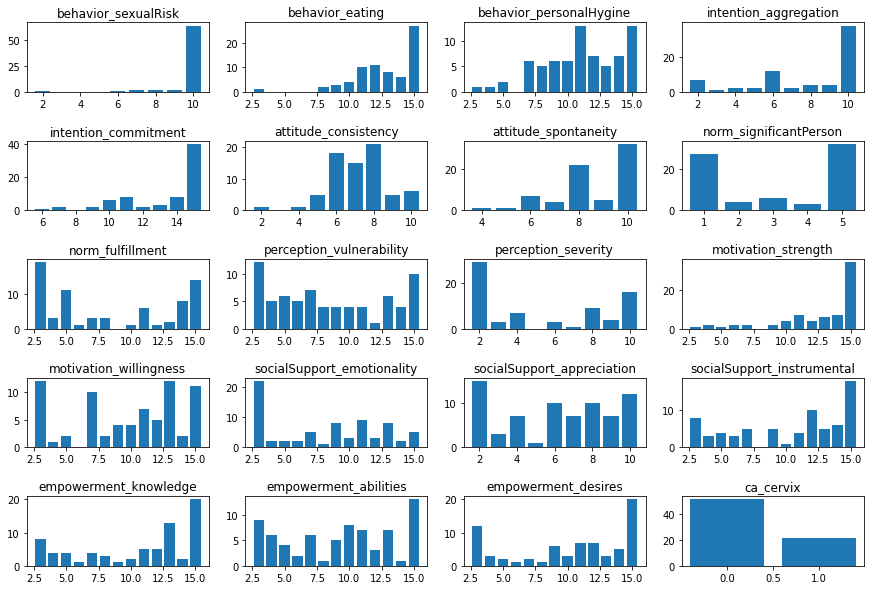

In [7]:
fig, ax = plt.subplots(5,4,figsize=(15,10))
axs = ax.flatten()
for ax,col in zip(axs,data.columns):
  c = data[col].value_counts()
  ax.bar(c.index, c.to_frame()[col])
  ax.title.set_text(col)

fig.subplots_adjust(wspace=0.2, hspace=0.7)
plt.show()

These plots gives us the "Count" of all the ratings given to a feature, here we could observe that there are few patterns by which we could infer that the relation with the target variable is more if the ratings are non uniformly distributed. But we have to satisfy this hypothesis with additional support. So, we will plot the heatmap.

The below plot shows the correlation between each features. We can observe that there are many redundant features which can be eliminated to reduce the model learning time. But as this is a very small dataset, we wont be able to preceive the difference.

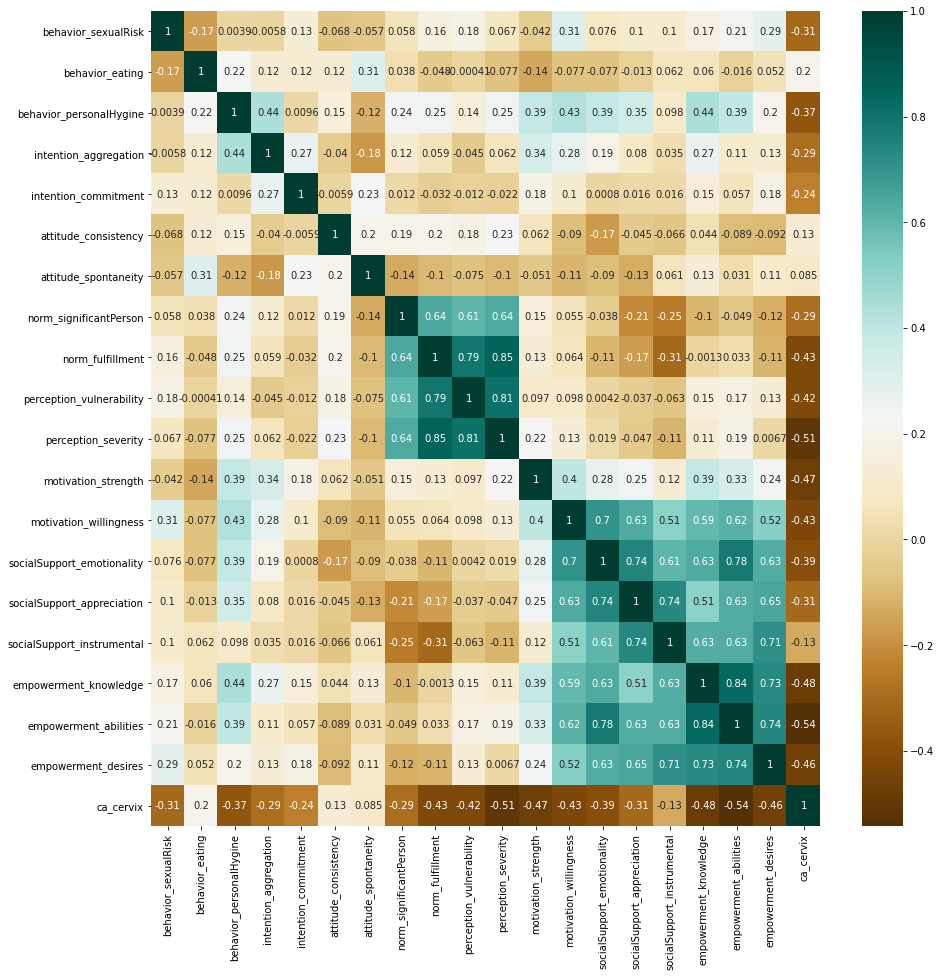

In [8]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(ax = ax, data = data.corr(), annot = True, cmap = 'BrBG')

The below plot shows the correlation of all the features with respect to the target variable "ca_cervix". As we could see, most of the features are inversely correlated with the target. with the most important being the "perception severity and empowerment ability".

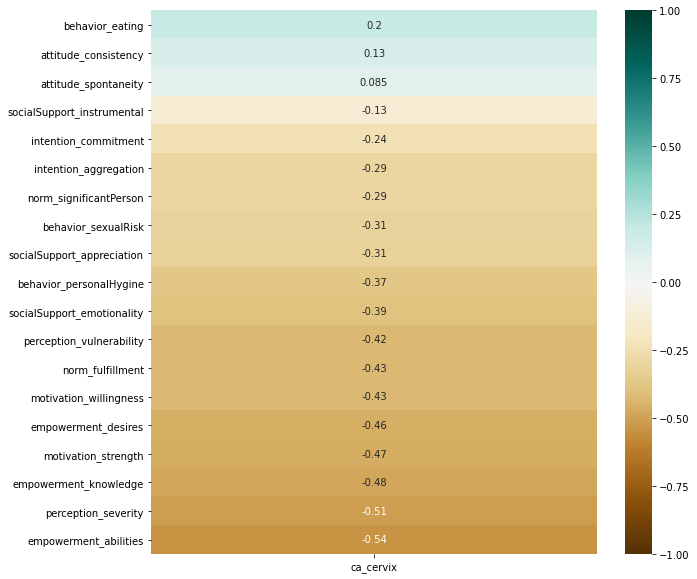

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ax = ax, data = data.corr()[['ca_cervix']].sort_values(by='ca_cervix', ascending=False)[1:],vmin=-1, vmax=1, annot = True, cmap='BrBG')

Here we will explore the features which differentiates the cancerous and non-cancerous patients. As we can observe, most of the features ratings doesn't show the difference between two groups

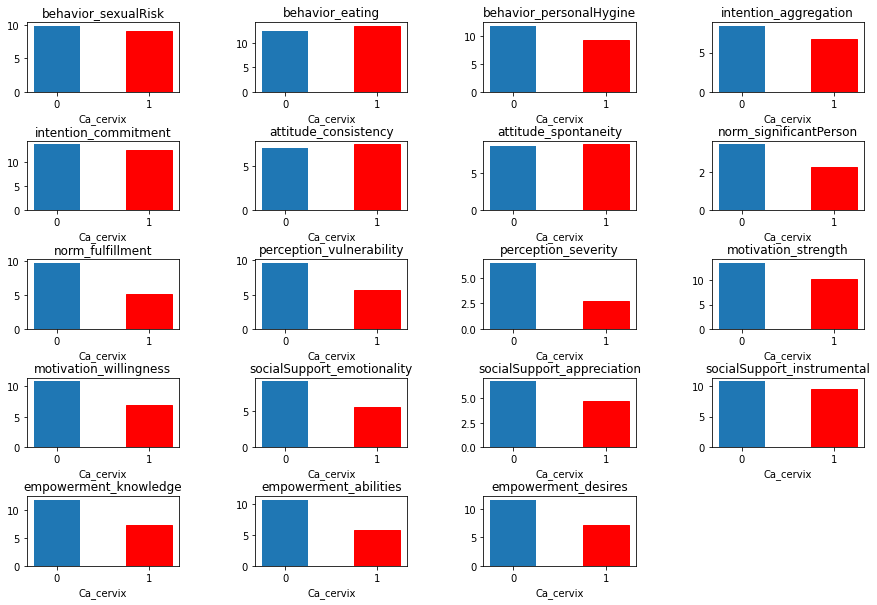

In [10]:
dg = data.groupby(by='ca_cervix').mean()
dg.reset_index(inplace=True)
fig, ax = plt.subplots(5,4,figsize=(15,10))
axs = ax.flatten()
for axes,col in zip(axs,cols):
    axes.bar(dg['ca_cervix'],dg[col],width=0.5)[1].set_color('r')
    axes.title.set_text(col)
    axes.set_xlabel('Ca_cervix')
    axes.set_xticks([0,1])
fig.delaxes(axs.flatten()[19])
fig.subplots_adjust(wspace=0.5, hspace=0.7)
plt.show()

Similar to the previous graph, here we will study the ratings patterns of each attribute and classify them into positive traits and negative traits.

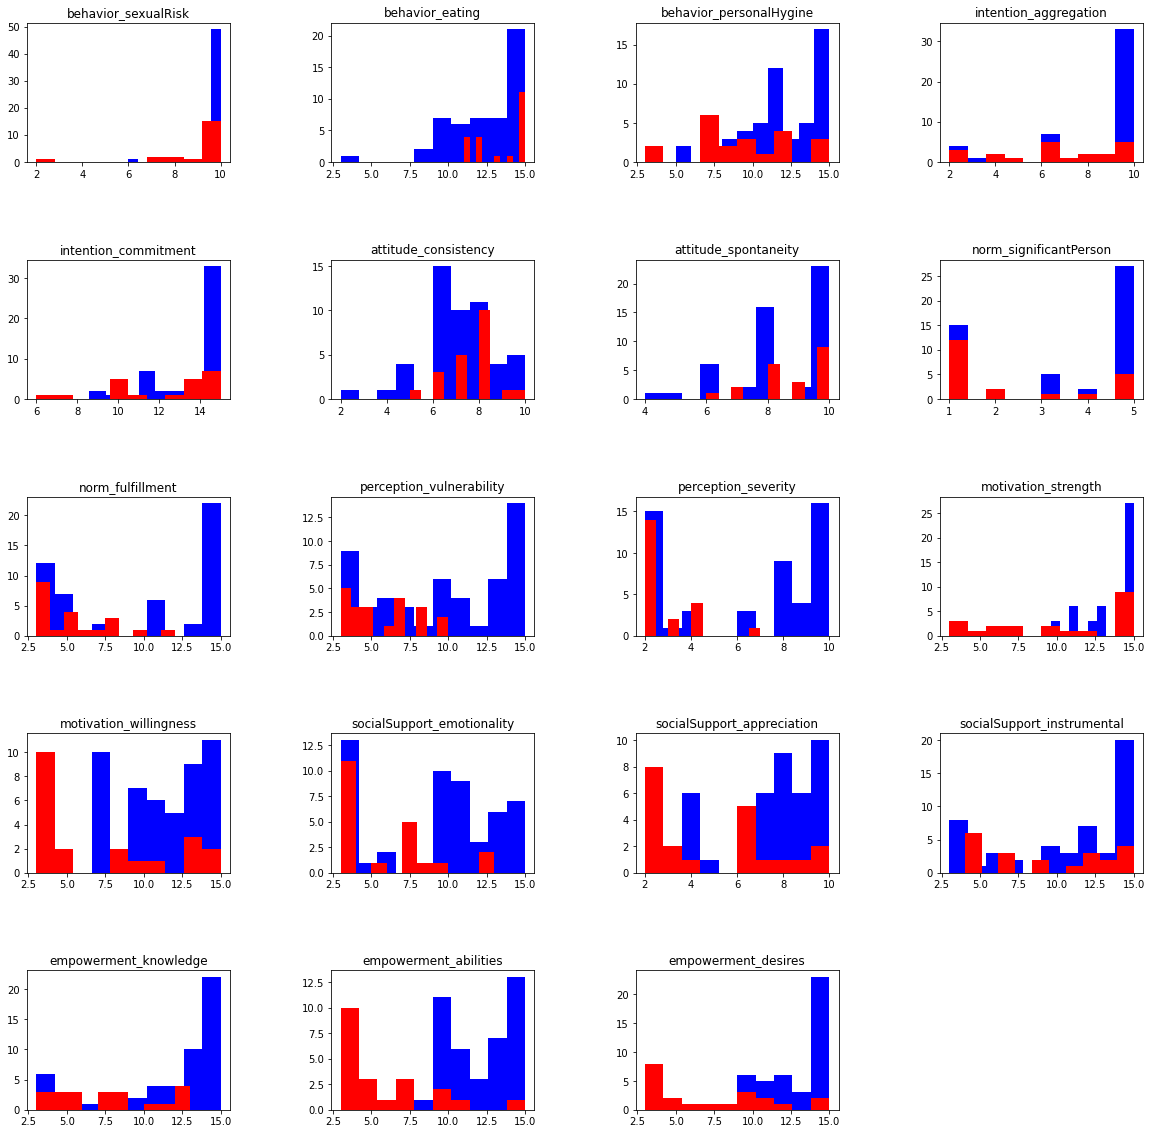

In [11]:
nca = data[data['ca_cervix']==0]
ca = data[data['ca_cervix']==1]
fig,axes = plt.subplots(5,4,figsize = (20,20))
axes = axes.flatten()
for co,ax in zip(cols,axes):
    ax.hist(data=nca, x = co ,label='no cancer',color = 'b')
    ax.hist(data=ca, x = co ,label = 'cancer',color = 'r')
    ax.title.set_text(co)
    
labels = ['no cancer', 'cancer']
plt.legend(labels)
fig.subplots_adjust(wspace=0.5, hspace=0.7)
fig.delaxes(axes[19])
plt.show()

As we have seen "perception severity" "behaviour ability" features differentiate two classes well, we will confirm that with another plot. The below plot shows us that they both are strongly related to each other. 

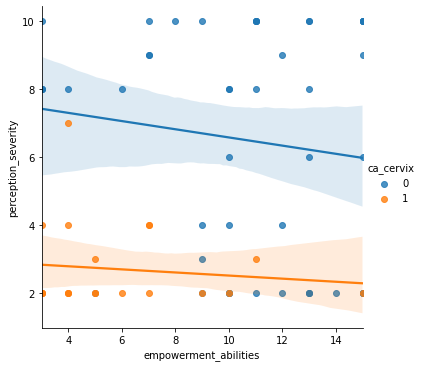

In [12]:
sns.lmplot(x = 'empowerment_abilities',y='perception_severity',data= data, hue= 'ca_cervix')

The below plot helps us in understanding the pattern between the social support attributes. The appreciation ratings doesn't differntiate two classes properly, But when the two attribute are given, the classes were easy to differentiate.

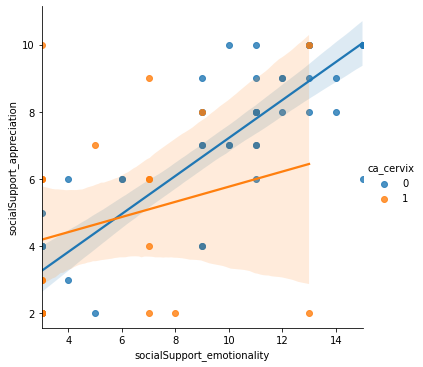

In [13]:
sns.lmplot(x = 'socialSupport_emotionality',y='socialSupport_appreciation',data= data, hue= 'ca_cervix')

The below scatter plots helps us to vizualize the relationship between few important attributes which we were not able to observe in previous plots.

In [14]:
def plot_features(feature1,feature2):
    print('Plotting feature ',feature1, 'and feature ',feature2)
    sns.scatterplot(x = data[feature1],y = data[feature2],hue = data['ca_cervix'].values,alpha=0.6)
    plt.legend(['cancer','no cancer'])
    plt.show()

Plotting feature  perception_vulnerability and feature  perception_severity


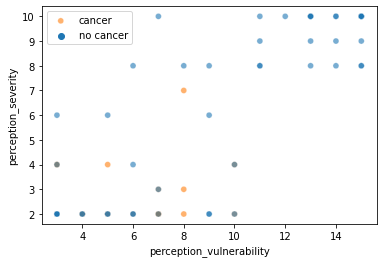

In [15]:
plot_features(columns[9],columns[10])

Plotting feature  norm_fulfillment and feature  perception_vulnerability


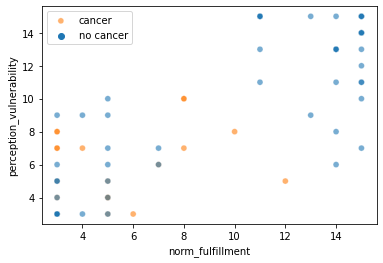

In [16]:
plot_features(columns[8],columns[9])

Plotting feature  empowerment_knowledge and feature  empowerment_desires


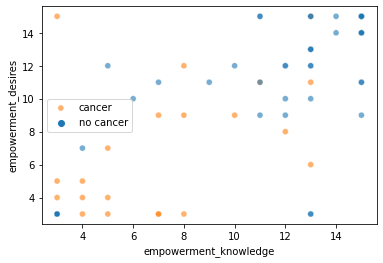

In [17]:
plot_features(columns[16],columns[18])

The below code helps us in filtering the important features, we can use this to reduce the number of attributes for the model to train faster. But as it is a small dataset, we will train with all the features to avoid losing the information.

In [18]:
correlation = data.corr()
imp_features = []
for i,c in enumerate(correlation['ca_cervix']):
    if c < -0.3:
        imp_features.append(correlation['ca_cervix'].index[i])
    elif c > 0.2:
        imp_features.append(correlation['ca_cervix'].index[i])

In [19]:
imp_features.remove('ca_cervix')
imp_features

['behavior_sexualRisk',
 'behavior_eating',
 'behavior_personalHygine',
 'norm_fulfillment',
 'perception_vulnerability',
 'perception_severity',
 'motivation_strength',
 'motivation_willingness',
 'socialSupport_emotionality',
 'socialSupport_appreciation',
 'empowerment_knowledge',
 'empowerment_abilities',
 'empowerment_desires']

# Question 3

### Preprocessing

As the dataset is already cleaned, we are just carrying out the preprocessing. The dataset is highly imbalanced, so, we will systhesize the data by oversampling the minority. 

And then we will perform Vector Assembly to combine all the features into a Dense vector to facilitate model training.

Then we will scale the features to make it evenly distributed. Although it is only usefull for logistic regression algorithm.


In [21]:
oversample = SMOTE()
x, y  = oversample.fit_resample(data[cols], data['ca_cervix'])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [23]:
x = pd.DataFrame(x,columns=cols)
y = pd.DataFrame(y,columns=['ca_cervix'])

In [24]:
data = pd.concat((x,y),axis=1)

In [25]:
spark= SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.csv('sobar-72.csv',header='True')

     |████████████████████████████████| 212.4 MB 64 kB/s 
     |████████████████████████████████| 198 kB 73.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=a9370305c9df8df15c1280a6ef5d36f3ed27e4efc5c90b4576ab078b292b77f1
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [26]:
for c in data.columns:
    df = df.withColumn(c,col(c).cast("double"))

In [27]:
stages = []
assembler = VectorAssembler(inputCols=cols, outputCol="features")
stages += [assembler]
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(df)
model = pipelineModel.transform(df)

In [28]:
df_model = model.select('ca_cervix','features')
df_model = df_model.selectExpr("features as features", "ca_cervix as label")
display(df_model)

DataFrame[features: vector, label: double]

In [29]:
train_data, test_data = df_model.randomSplit([0.8,0.2],seed=1234)

In [30]:
scaler = StandardScaler(inputCol='features',outputCol='sfeatures')
scalerModel =  scaler.fit(train_data)
train_data = scalerModel.transform(train_data)
test_data = scalerModel.transform(test_data)

In [31]:
display(train_data.take(2))

[Row(features=DenseVector([2.0, 15.0, 15.0, 6.0, 13.0, 8.0, 9.0, 1.0, 3.0, 3.0, 4.0, 15.0, 3.0, 7.0, 6.0, 7.0, 7.0, 7.0, 3.0]), label=1.0, sfeatures=DenseVector([1.6219, 6.0205, 4.8108, 2.1117, 6.0209, 5.3994, 5.555, 0.5435, 0.6081, 0.7305, 1.2116, 5.3944, 0.7571, 1.7138, 2.1222, 1.6794, 1.6351, 1.6642, 0.6918])),
 Row(features=DenseVector([7.0, 15.0, 7.0, 6.0, 11.0, 8.0, 8.0, 5.0, 3.0, 3.0, 4.0, 15.0, 3.0, 8.0, 2.0, 9.0, 3.0, 4.0, 4.0]), label=1.0, sfeatures=DenseVector([5.6767, 6.0205, 2.245, 2.1117, 5.0946, 5.3994, 4.9378, 2.7173, 0.6081, 0.7305, 1.2116, 5.3944, 0.7571, 1.9586, 0.7074, 2.1592, 0.7008, 0.951, 0.9224]))]

# Question 4

### Decision Tree

Due to very few number of patient records, It is not suitable to implement random forest, so we have chosen a simple version Decision Tree.

Decision tree is also a non-parametric model and tries to best fit the underlying distribution of the data

In [33]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="sfeatures")
clf = dt.fit(train_data)
pred = clf.transform(test_data)

In [34]:
pred

DataFrame[features: vector, label: double, sfeatures: vector, rawPrediction: vector, probability: vector, prediction: double]

In [35]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Error rate = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Error rate = 0.235294 
Accuracy = 0.764706 


### Naive Bayes

Naive Bayes implicitly treats all features as being independent of one another and the estimates are based on the joint density function. So, this algorithm is suitable.

In [36]:
nb = NaiveBayes(labelCol="label", featuresCol="sfeatures")
clf1 = nb.fit(train_data)
preds = clf1.transform(test_data)

In [37]:
preds.show()

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            features|label|           sfeatures|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|[6.0,15.0,11.0,10...|  0.0|[4.86578044193560...|[-181.06665423087...|[0.96260437729445...|       0.0|
|[8.0,11.0,7.0,8.0...|  1.0|[6.48770725591414...|[-136.05180830978...|[0.31887988272463...|       1.0|
|[10.0,11.0,10.0,1...|  1.0|[8.10963406989268...|[-147.33770033577...|[0.49320072873313...|       1.0|
|[10.0,11.0,12.0,2...|  1.0|[8.10963406989268...|[-131.27374963142...|[0.76153162458774...|       0.0|
|[10.0,11.0,14.0,1...|  0.0|[8.10963406989268...|[-211.77616913747...|[0.98887904084997...|       0.0|
|[10.0,11.0,15.0,1...|  0.0|[8.10963406989268...|[-214.92105159050...|[0.99607460929062...|       0.0|
|[10.0,12.0,7.0,5....|  1.0|[8.10963406989268...|[-125.11947696273...|[0.

In [38]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(preds)
print("Error rate = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Error rate = 0.176471 
Accuracy = 0.823529 


In [92]:
metrics = BinaryClassificationMetrics(preds['label','prediction'].rdd)
print('Area under ROC: ',metrics.areaUnderROC)
print('Area under precision recall curve ',metrics.areaUnderPR)

Area under ROC:  0.8928571428571428
Area under precision recall curve  0.5


### Logistic Regression

The penalized maximum likelihood estimation is mathematically identical to Bayesian analysis, which avoids overfitting. so it is suitable for small datasets.

In [85]:
from pyspark.ml.classification import LogisticRegression

In [86]:
lr = LogisticRegression(labelCol="label", featuresCol="sfeatures")
clf2 = lr.fit(train_data)
predslr = clf2.transform(test_data)

DataFrame[features: vector, label: double, sfeatures: vector, rawPrediction: vector, probability: vector, prediction: double]

In [95]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predslr)
print("Error rate = %g " % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)
metrics = BinaryClassificationMetrics(predslr['label','prediction'].rdd)
print('Area under ROC: ',metrics.areaUnderROC)
print('Area under precision recall curve ',metrics.areaUnderPR)

Error rate = 0.0588235 
Accuracy = 0.941176 
Area under ROC:  0.9285714285714286
Area under precision recall curve  0.9579831932773109


# Question 5

### Hyperparameter Tuning

### Decision Tree

In [66]:
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth,[2,3,4,10,20])\
            .addGrid(dt.maxBins,[2,5,7,10,15])\
            .addGrid(dt.impurity,['gini','entropy'])\
            .addGrid(dt.minInstancesPerNode,[3,6,9])\
            .build()

cvEvaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=cvEvaluator)
cvModel = cv.fit(train_data)

cvPredictions = cvModel.transform(test_data)

evaluator.evaluate(cvPredictions)
print('Accuracy:', cvEvaluator.evaluate(cvPredictions))
print('AUC:', BinaryClassificationMetrics(cvPredictions['label','prediction'].rdd).areaUnderROC)
print('PR:', BinaryClassificationMetrics(cvPredictions['label','prediction'].rdd).areaUnderPR)

Accuracy: 0.893939393939394
AUC: 0.9583333333333333


In [81]:
best = cvModel.bestModel
maxBins = best._java_obj.getMaxBins()
maxDepth = best._java_obj.getMaxDepth()
impurity = best._java_obj.getImpurity()
minInstancesPerNode = best._java_obj.getMinInstancesPerNode()
print('Best model parameters :\n maxDepth: {}\n maxBins: {}\n Impurity : {}\n minInstancesPerNode : {}'.format(maxDepth, maxBins,impurity,minInstancesPerNode))

Best model parameters :
 maxDepth: 2
 maxBins: 10
 Impurity : gini
 minInstancesPerNode : 6


### Naive Bayes

In [83]:
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0])\
            .addGrid(nb.modelType,['multinomial','complement','gaussian'])\
            .build()
cvEvaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=cvEvaluator)
cvModel = cv.fit(train_data)
cvModel.bestModel

cvPredictions = cvModel.transform(test_data)

evaluator.evaluate(cvPredictions)
print('Accuracy:', cvEvaluator.evaluate(cvPredictions))
print('AUC:', BinaryClassificationMetrics(cvPredictions['label','prediction'].rdd).areaUnderROC)
print('PR :', BinaryClassificationMetrics(cvPredictions['label','prediction'].rdd).areaUnderPR)

Accuracy: 0.9545454545454545
AUC: 0.8712121212121212


In [84]:
best = cvModel.bestModel
model_type = best._java_obj.getModelType()
smoothing = best._java_obj.getSmoothing()
print('Best model parameters :\n model type: {}\n smoothing : {}'.format(model_type,smoothing))

Best model parameters :
 model type: complement
 smoothing : 0.0


### Logistic regression

In [100]:
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.001,0.01,0.1])\
            .addGrid(lr.maxIter, [15,20,30])\
            .addGrid(lr.threshold,[0.2,0.3,0.6])\
            .addGrid(lr.standardization, [True, False])\
            .build()
cvEvaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=cvEvaluator)
cvModel = cv.fit(train_data)
cvModel.bestModel

cvPredictions = cvModel.transform(test_data)

evaluator.evaluate(cvPredictions)
print('Accuracy:', cvEvaluator.evaluate(cvPredictions))
print('AUC:', BinaryClassificationMetrics(cvPredictions['label','prediction'].rdd).areaUnderROC)
print('PR :', BinaryClassificationMetrics(cvPredictions['label','prediction'].rdd).areaUnderPR)

Accuracy: 0.9545454545454545
AUC: 0.8333333333333333
PR : 0.9215686274509804


In [101]:
best = cvModel.bestModel
reg = best._java_obj.getRegParam()
maxiter = best._java_obj.getMaxIter()
threshold = best._java_obj.getThreshold()
std = best._java_obj.getStandardization()
print('Best model parameters :\n reg param: {}\n maxIter : {}\n threshold : {}\n standardization : {}'.format(reg,maxiter,threshold,std))

Best model parameters :
 reg param: 0.01
 maxIter : 20
 threshold : 0.2
 standardization : False


The above results are obtained after perfoming hyperparameter tuning, as we could see most of the metrics shows improvement. It can be further optimized by some more parameters aswell.